In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import sounddevice as sd

# Importe la fonction gamme du fichier gamme.py
from gamme import gamme

# Importe la fonction plot_filtered_signal du fichier utils.py
from utils import plot_filtered_signal, plot_filter_frequential_responses

In [2]:
# Fréquences d'échantillonnage et de tracé
duree = 12  # en secondes
fe = 1024*16  # Fréquence d'échantillonnage (Hz)
fmin = 250  # Fréquence minimale de tracé (Hz)
fmax = 800  # Fréquence maximale de tracé (Hz)

In [3]:
# Retourne le signal en fonction du temps
sig, t = gamme(duree, fe)

In [4]:
print(sd.query_devices())
sd.default.device = 1
print(sd.query_devices())

  0 vc4-hdmi-0: MAI PCM i2s-hifi-0 (hw:0,0), ALSA (0 in, 2 out)
  1 bcm2835 Headphones: - (hw:2,0), ALSA (0 in, 8 out)
  2 sysdefault, ALSA (0 in, 128 out)
  3 hdmi, ALSA (0 in, 2 out)
  4 pulse, ALSA (32 in, 32 out)
* 5 default, ALSA (32 in, 32 out)
  0 vc4-hdmi-0: MAI PCM i2s-hifi-0 (hw:0,0), ALSA (0 in, 2 out)
* 1 bcm2835 Headphones: - (hw:2,0), ALSA (0 in, 8 out)
  2 sysdefault, ALSA (0 in, 128 out)
  3 hdmi, ALSA (0 in, 2 out)
  4 pulse, ALSA (32 in, 32 out)
  5 default, ALSA (32 in, 32 out)


In [5]:
# Joue le signal audio
sd.play(sig, fe)
sd.wait()  # Attend la fin de la lecture

In [6]:
# Transformée de Fourier de notre signal
S = np.fft.fft(sig) / fe
f = np.fft.fftfreq(sig.shape[0], d=1/fe)

In [7]:
# # Affiche le spectre du signal original
# plt.plot(f, np.abs(S))
# plt.xlim([fmin, fmax])
# plt.xlabel('Fréquence (Hz)')
# plt.ylabel('Amplitude')
# plt.show()

In [8]:
# Spécifications du filtre coupe bande
Ap = 1     # Atténuation maximale en bande passante (dB)
Aa = 40    # Atténuation minimale en bande atténuée (dB)
fbc = 340   # Fréquence de coupure (Hz)
fhc = 360   # Fréquence de coupure (Hz)
df = 10   # Largeur de la bande de transition (Hz)

In [9]:
# Définition des fréquences de la bande passante et de la bande atténuée
fbp = fbc - df/2
fba = fbc + df/2
fhp = fhc + df/2
fha = fhc - df/2

fpass = [fbp, fhp]
fstop = [fba, fha]

# Normalisation
Fp = [f / (fe/2) for f in fpass]
Fs = [f / (fe/2) for f in fstop]

Ordre du filtre de Chebyshev de type 2 :  4


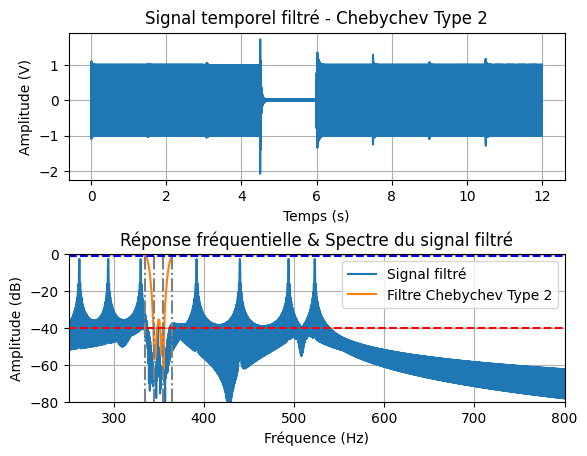

In [10]:
###################################################################
################### RII - Filtre coupe bande ######################
###################################################################

# Calcul de l'ordre et des coefficients du filtre de Chebyshev de type 2
[n_Chebychev, wn_Chebychev] = signal.cheb2ord(Fp, Fs, Ap, Aa)
[Num_Chebychev2, Deno_Chebychev2] = signal.cheby2(n_Chebychev, Aa, wn_Chebychev, btype='stop')

# Affichage de l'ordre du filtre
print('Ordre du filtre de Chebyshev de type 2 : ', n_Chebychev)

# Calcul de la réponse fréquentielle du filtre
w_Chebychev2, H_Chebychev2 = signal.freqz(Num_Chebychev2, Deno_Chebychev2, worN=10000) # worN = 10000 pour avoir une meilleure résolution

# Crée l'objet LTI à partir des coefficients du filtre
filtre_Chebychev2 = signal.lti(Num_Chebychev2, Deno_Chebychev2)

# Filtrage du signal
sig_filtre_Chebychev2 = signal.lfilter(Num_Chebychev2, Deno_Chebychev2, sig)

# Tracé du signal filtré et de sa réponse fréquentielle
plot_filtered_signal(t=t, sig_filtre=sig_filtre_Chebychev2, f=f, H=H_Chebychev2, w_norm=w_Chebychev2*fe, fe=fe, fmin=fmin, fmax=fmax, Ap=Ap, Aa=Aa, fc=[fbc, fhc], df=df, title='Chebychev Type 2')

# Joue le signal audio filtré
sd.play(sig_filtre_Chebychev2, fe)
sd.wait()  # Attend la fin de la lecture

Ordre du filtre de Kaiser : 3659


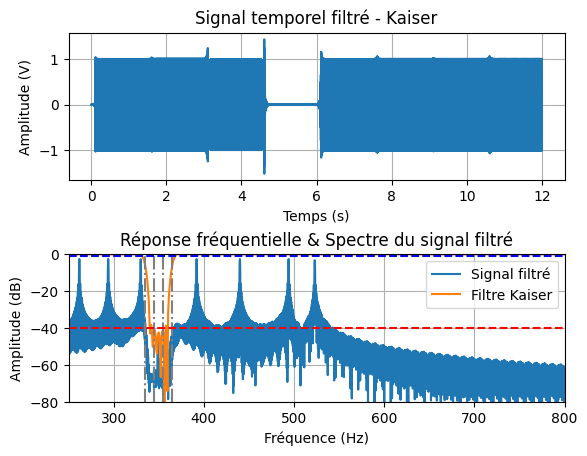

In [11]:
###################################################################
################### RIF - Filtre coupe bande ######################
###################################################################

# Calcul de l'ordre et des coefficients du filtre de Kaiser
ep = 1 - 10**(-Ap/20)
da = 10**(-(Aa+3.5)/20)
wn = [fbp/fe, fba/fe, fha/fe, fhp/fe]
desired = [1, 0, 1]
weight = [ep, da, ep]

nyquist_rate = fe/2 # Nyquist rate

# Calcul de l'ordre du filtre
N, beta = signal.kaiserord(Aa, df/nyquist_rate)

# Ensure N is odd
if N % 2 == 0:
    N += 1
h = signal.firwin(numtaps=N, cutoff=Fp, window=('kaiser', beta)) # pass_zero=False pour un filtre passe-bande sinon réjecteur de bande

# Affichage de l'ordre du filtre
print(f"Ordre du filtre de Kaiser : {N}")

# Calcul de la réponse fréquentielle du filtre
w_Kaiser, H_Kaiser = signal.freqz(h, worN=10000) # worN = 10000 pour avoir une meilleure résolution

# Filtrage du signal
sig_filtre_Kaiser = signal.lfilter(h, 1.0, sig)

# Tracé du signal filtré et de sa réponse fréquentielle
plot_filtered_signal(t=t, sig_filtre=sig_filtre_Kaiser, f=f, H=H_Kaiser, w_norm=w_Kaiser*fe, fe=fe, fmin=fmin, fmax=fmax, Ap=Ap, Aa=Aa, fc=[fbc, fhc], df=df, title='Kaiser')

# Joue le signal audio filtré
sd.play(sig_filtre_Kaiser, fe)
sd.wait()  # Attend la fin de la lecture

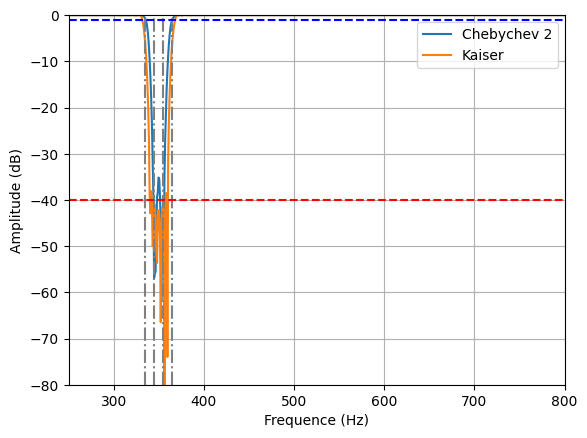

In [12]:
###################################################################
########################### RIF vs RII ############################
###################################################################

# Comparaison des réponses fréquentielles des filtres
plot_filter_frequential_responses(filters=[(w_Chebychev2*fe, H_Chebychev2, 'Chebychev 2'), (w_Kaiser*fe, H_Kaiser, 'Kaiser')], fmin=fmin, fmax=fmax, Ap=Ap, Aa=Aa, fc=[fbc, fhc], df=df)